## Cats and dogs V3

### **Submitted by: BEBENSEE BJOERN (2019-21343)**

####**Designed by Joon Son Chung, October 2020**

This is a running example.

Here, instead of heights and weights, we design a simple CNN to classify images of cats and dogs.

I got these by selecting some cats and dogs from the 32x32 ImageNet data. We call this C&D dataset from now on.

In [ ]:
from google.colab import drive
import os, glob, sys, numpy, cv2, random

drive.mount('/content/drive', force_remount=True)

# path relative to the home folder of Drive
FOLDER = 'Colab Notebooks/catsanddogs_v3' ##### FILL THIS IN #####

# check runtime type
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
Sun Oct 11 13:51:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8     9W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                              

In the previous exercise, we defined the dataset and the data loader manually. It is easier to define the dataset as `torch.utils.data.Dataset`. The class must have at least two functions: `__getitem__` and `__len__`. See https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset and the example below to see how to use it. It is essential that you understand what these two functions do. The following defines the behaviour of the C&D dataset.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

class catsanddogs(torch.utils.data.Dataset):
    def __init__(self, data_path, train, transform=None):

        self.transform = transform

        if train:
          dog_path = os.path.join('/content/drive/My Drive',data_path,'dogs250.npy')
          cat_path = os.path.join('/content/drive/My Drive',data_path,'cats250.npy')
        else:
          dog_path = os.path.join('/content/drive/My Drive',data_path,'dogs_val.npy')
          cat_path = os.path.join('/content/drive/My Drive',data_path,'cats_val.npy')

        # load imagenet data - this is already in numpy format
        cat_imgs = numpy.load(cat_path)
        dog_imgs = numpy.load(dog_path)

        # change linear array to 3D matrices
        cat_imgs = cat_imgs.reshape((-1,3,32,32))
        dog_imgs = dog_imgs.reshape((-1,3,32,32))

        # make labels
        self.data   = numpy.concatenate((cat_imgs,dog_imgs),axis=0)
        self.data   = self.data.transpose((0, 2, 3, 1))
        self.label  = numpy.array([0]*len(cat_imgs)+[1]*len(dog_imgs))

        print('Size of data is', self.data.shape)
        print('Size of label is',self.label.shape)

    def __getitem__(self, index):

      img, target = self.data[index], self.label[index]
      img = Image.fromarray(img)
      if self.transform is not None:
            img = self.transform(img)
      return img, target

    def __len__(self):
      return len(self.data)

Define the transformation that turns PIL image into normalised Pytorch input.

**Do not change the following section.**

In [ ]:
# Transformation to normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

Call the dataset and initiate the loader.

In [ ]:
trainset = catsanddogs(FOLDER, train=True, transform=transform)
testset   = catsanddogs(FOLDER, train=False, transform=transform)

cndtrainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
cndtestloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('cat','dog')

Size of data is (500, 32, 32, 3)
Size of label is (500,)
Size of data is (500, 32, 32, 3)
Size of label is (500,)


This script helps you visualise the input as a form of sanity check.

tensor(0.0781)
  dog   dog   cat   dog   dog


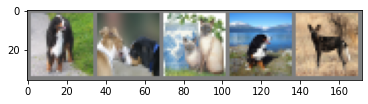

In [ ]:
import matplotlib.pyplot as plt
import torchvision
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(numpy.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(cndtestloader)
images, labels = dataiter.next()

images = images[:5,:,:,:]

print(torch.mean(images.type(torch.FloatTensor)))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(images))))

We define the model and the optimizer. The model contains two conv layers followed by a set of fully connected layers. The output dimension of the last FC layer (fc3) must be the number of output classes (e.g. 10 for CIFAR 10).

Redundant classes (more classes than necessary) usually do not have much negative effect on performance as long as the network is trained for long enough, but you can never have fewer classes than in the dataset.

**Do not change the following section, since I want everyone to use the same architecture.**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## We define the model.
class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveMaxPool2d(1),
        )


        self.fc_layer = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            
            nn.Linear(512, 2)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

classifier = CNN()

## Move model to GPU
classifier = classifier.cuda()
classifier.train()

## We also define the optimizer.
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

print('Network initialised')

Network initialised


Now, we train the network. 

We test the trained model for 50 epochs. An epoch is defined as one full pass through the training data.

This will take a few minutes to run.

In [ ]:
def train_network(net, trainloader, testloader, optimizer, max_epoch=50):

  ## We also define the loss function.
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(0, max_epoch):

    ## Put the network in training mode
    net.train()

    correct = 0
    total = 0

    for it, data in enumerate(trainloader, 0):

      # get the inputs
      x_batch, y_batch = data
      x_batch = x_batch.cuda()
      y_batch = y_batch.cuda()

      ## Forward pass through the network
      y_pred = net(x_batch).squeeze()
      loss = criterion(y_pred,y_batch)

      ## Backward pass
      loss.backward()

      ## Optimizer step
      optimizer.step()
      optimizer.zero_grad()

      ## Calculate accuracy
      _, label_pred = torch.max(y_pred, 1)
      total   += y_batch.size(0)
      correct += (label_pred == y_batch).sum().item()

    train_acc = 100 * correct / total

    ## After every epoch, check the test performance

    ## Put the network in test mode
    net.eval()

    correct = 0
    total = 0
    
    for data in testloader:

      # get the inputs
      x_batch, y_batch = data
      x_batch = x_batch.cuda()
      y_batch = y_batch.cuda()

      ## Forward pass through the network without gradient computation
      with torch.no_grad():
        y_pred  = net(x_batch)
        _, label_pred = torch.max(y_pred.data, 1)
        total   += y_batch.size(0)
        correct += (label_pred == y_batch).sum().item()

    test_acc = 100 * correct / total

    print('Epoch','{:d}'.format(epoch),'Loss','{:.3f}'.format(loss.item()),'Train accuracy','{:.1f}'.format(train_acc),'Test accuracy','{:.1f}'.format(test_acc))



Having defined the training function, actually train the network

In [ ]:
train_network(classifier,cndtrainloader,cndtestloader,optimizer,max_epoch=100)

Epoch 0 Loss 0.694 Train accuracy 50.0 Test accuracy 50.0
Epoch 1 Loss 0.683 Train accuracy 53.6 Test accuracy 50.0
Epoch 2 Loss 0.683 Train accuracy 57.8 Test accuracy 50.0
Epoch 3 Loss 0.700 Train accuracy 55.2 Test accuracy 50.0
Epoch 4 Loss 0.663 Train accuracy 63.6 Test accuracy 50.0
Epoch 5 Loss 0.650 Train accuracy 65.0 Test accuracy 50.0
Epoch 6 Loss 0.664 Train accuracy 65.8 Test accuracy 49.8
Epoch 7 Loss 0.550 Train accuracy 70.4 Test accuracy 51.6
Epoch 8 Loss 0.561 Train accuracy 70.8 Test accuracy 50.4
Epoch 9 Loss 0.553 Train accuracy 72.8 Test accuracy 50.0
Epoch 10 Loss 0.446 Train accuracy 77.2 Test accuracy 50.0
Epoch 11 Loss 0.332 Train accuracy 81.8 Test accuracy 50.6
Epoch 12 Loss 0.346 Train accuracy 89.6 Test accuracy 61.8
Epoch 13 Loss 0.259 Train accuracy 94.8 Test accuracy 53.0
Epoch 14 Loss 0.165 Train accuracy 95.2 Test accuracy 58.0
Epoch 15 Loss 0.111 Train accuracy 98.2 Test accuracy 66.0
Epoch 16 Loss 0.032 Train accuracy 98.8 Test accuracy 55.6
Epoch 1

Evaluate test performance offline



In [ ]:
correct = 0
total = 0

for data in cndtestloader:

  # get the inputs
  x_batch, y_batch = data
  x_batch = x_batch.cuda()
  y_batch = y_batch.cuda()

  with torch.no_grad():
    ## Forward pass through the network
    y_pred  = classifier(x_batch)
    _, label_pred = torch.max(y_pred.data, 1)
    total   += y_batch.size(0)
    correct += (label_pred == y_batch).sum().item()

print('Test set size is %d'%(total))
print('Accuracy over the whole test set is %.3f percent' % (100 * correct / total) )

Test set size is 500
Accuracy over the whole test set is 68.200 percent


Try your own image. I recommend that you use an image in JPG format.

Size of x is torch.Size([1, 3, 32, 32])
Output is dog with probability 0.9086529016494751


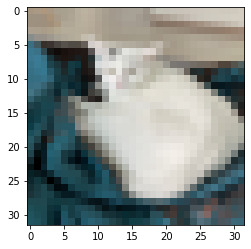

In [ ]:
## Read image from file and resize to 64 x 64
image = Image.open(os.path.join('/content/drive/My Drive',FOLDER,'아갱1.jpg')).resize((32,32))

## Convert PIL image to network input as given by
x = transform(image).unsqueeze(0)

## Check that the dimension is the same as in training
print('Size of x is',x.size())

classifier.eval()

with torch.no_grad():
  y_pred = classifier(x.cuda())
  y_prob = torch.nn.functional.softmax(y_pred,dim=1)

plt.imshow(image, cmap='gray')

print('Output is',classes[torch.argmax(y_prob)],'with probability',torch.max(y_prob).item())

The code to download the CIFAR10 dataset is in the `torchvision` package. You can call the dataset using the following code.

In [ ]:
cifartrainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifartrainloader = torch.utils.data.DataLoader(cifartrainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

cifartestset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
cifartestloader = torch.utils.data.DataLoader(cifartestset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Please do the following.

0.   Visualise the CIFAR dataset
1.   Change the number of model output classes to 10, and re-initialise the network.
2.   Train the network on CIFAR train set for 20 epochs. The performance on CIFAR test set should be around 83%.
3.   Evaluate the network on C&D test set. (Requires some thought!)
4.   Finetune all layers C&D train set for 50 epochs. Set learning rate for `conv_layer` as 0.001 and for `fc_layer` as 0.01. You will need to define a new optimizer.
5.   Re-evaluate the network on C&D test set.

Show the code that you wrote to do the assignment. You may choose to define functions for training, testing, etc., but how you organise the code is completely up to you.

**Something to think about**: cats and dogs are classes 0 and 1 in the C&D datasets, but classes 3 and 5 in the CIFAR10 dataset. How would you use the network trained on CIFAR10 training set and then test on the C&D test set? Hint: there are many ways to do this, but consider changing the following lines in the sections above:


```
self.label  = numpy.array([0]*len(cat_imgs)+[1]*len(dog_imgs))
...
classes = ('cat','dog')
...
nn.Linear(512, 2)
```

You can define different learning rates for different layers as follows. The following would set LR of 0.1 to `layer1` and 0.01 to `layer2`.

```
optimizer2 = torch.optim.SGD([
                {'params': net.layer1.parameters()},
                {'params': net.layer2.parameters(), 'lr': 0.01}
            ], lr=0.1, momentum=0.9)
```

Finally, fill the following table. The results will vary slightly every time you run the code, because of the randomness in batch formation and network initialisation. However, the results should be quite similar for everyone.




### Results tested on the C&D test set

Remember you are reporting the test accuracy on the **C&D** test set, not CIFAR10 test set. The evaluation should be done offline (outside of the training function).

Expected results are approximate.

| Train set                           | Test set   | Your result | Expected result |
|------------------------------------|-------------|-------------|-----------------|
| C&D train set          |      C&D test set       |    68.2%   |    70%          |
| CIFAR10 train set       |      C&D test set       |    66.2%       |    70%          |
| CIFAR10 train set, FT on C&D train set |  C&D test set    |     77.4%      |    77%          |



If you have any comments or difficulties, please write below.

[*Write here*]




## Write your code below

**0. Visualising the CIFAR dataset:** similarly to the cats and dogs dataset we retrieve random training images from the dataset using the dataloader. We print 8 examples and we can already see some examples for cats and dogs in the dataset.

Data dimensions: torch.Size([100, 3, 32, 32]) torch.Size([100])
tensor(0.0931)
 bird  frog plane   car truck   car  ship   dog


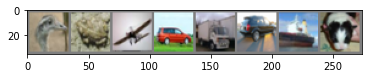

In [ ]:
# get some random training images
dataiter = iter(cifartrainloader)
images, labels = dataiter.next()

print("Data dimensions:", images.size(), labels.size())

images = images[:8,:,:,:]

print(torch.mean(images.type(torch.FloatTensor)))

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(images))))

Next, let us specifically look at some examples for cats and dogs in the CIFAR dataset vs examples in the cats vs dogs test set, since the shared features between these will be relevant to our test case. In particular, differences in the data distributions can have an impact on final classification accuracy.

  CIFAR   CIFAR   CIFAR  C&D   C&D   C&D  


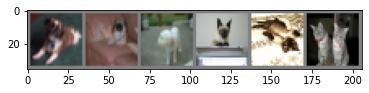

In [ ]:
cndimages, cndlabels = iter(cndtestloader).next()
cifarimages, cifarlabels = iter(cifartrainloader).next()

# only keep dog and cat examples for CIFAR, filter out the rest
cifarimages = [cifarimages[i,:,:,:].unsqueeze(0) for i in range(100) if cifarlabels[i] in [3,5]]
cifarimages = torch.cat(cifarimages, axis=0)

cndimages = cndimages[:3,:,:,:]
cifarimages = cifarimages[:3,:,:,:]
images = torch.cat([cifarimages[:4,:,:,:], cndimages[:4,:,:,:]], axis=0)
labels = torch.cat([cifarlabels[:4], cndlabels[:4]], axis=0)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print('  CIFAR ' * 3 + ' C&D  ' * 3)

We can see that the images are relatively similar (at least for these sampled example images) and there appear to be no major differences between the datasets such as backgrounds having been removed, etc.

**1. Changing the number of model output classes to 10, and re-initialising the network:** This has been done in the code below by simply changing the final nn.Linear() to have an output dimension of 10 and then initializing this new CNN. The code is copy-pasted from above for convenience so that we can run this notebook from top to bottom rather than manually changing the output dimension and re-running the cell every time we want to re-run the notebook.

In [ ]:
## Architecture is copy-pasted from above architecture (simply for convenience of being able to run this notebook from top to bottom)
class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveMaxPool2d(1),
        )


        self.fc_layer = nn.Sequential(
            nn.Linear(256, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

classifier = CNN()

## Move model to GPU
classifier = classifier.cuda()
classifier.train()

## We also define the optimizer.
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

print('Network initialised')

Network initialised


**2.   Train the network on CIFAR train set for 20 epochs:** We run the re-initialized CNN model with the provided training function by simply providing the CIFAR train and test loaders.

In [ ]:
train_network(classifier, cifartrainloader, cifartestloader, optimizer, max_epoch=20)

Epoch 0 Loss 1.142 Train accuracy 44.5 Test accuracy 56.1
Epoch 1 Loss 0.762 Train accuracy 69.1 Test accuracy 74.2
Epoch 2 Loss 0.653 Train accuracy 77.5 Test accuracy 77.8
Epoch 3 Loss 0.771 Train accuracy 82.1 Test accuracy 80.6
Epoch 4 Loss 0.481 Train accuracy 85.6 Test accuracy 80.2
Epoch 5 Loss 0.369 Train accuracy 87.7 Test accuracy 81.9
Epoch 6 Loss 0.213 Train accuracy 89.8 Test accuracy 82.8
Epoch 7 Loss 0.240 Train accuracy 91.7 Test accuracy 84.9
Epoch 8 Loss 0.164 Train accuracy 93.0 Test accuracy 82.9
Epoch 9 Loss 0.217 Train accuracy 94.3 Test accuracy 82.7
Epoch 10 Loss 0.281 Train accuracy 95.4 Test accuracy 83.0
Epoch 11 Loss 0.075 Train accuracy 96.0 Test accuracy 84.0
Epoch 12 Loss 0.097 Train accuracy 96.7 Test accuracy 83.6
Epoch 13 Loss 0.093 Train accuracy 97.0 Test accuracy 84.0
Epoch 14 Loss 0.094 Train accuracy 97.5 Test accuracy 82.1
Epoch 15 Loss 0.091 Train accuracy 97.8 Test accuracy 83.5
Epoch 16 Loss 0.099 Train accuracy 98.0 Test accuracy 85.3
Epoch 1

**3.   Evaluate the network on C&D test set:** We modify the labels of the C&D dataset to fit the label IDs found in the CIFAR dataset. We define an evaluation function that runs an evluation loop over the entire test set for a given network. It is important to keep in mind that during inference/evaluation we can ignore the other classes and only focus on whether the image is more likely to be a cat or a dog (since there are only cats and dogs in the C&D test set). Then we run said evaluation function for our architecture that has been trained on the CIFAR dataset for 20 epochs. 

In [ ]:
class catsanddogsCIFAR(torch.utils.data.Dataset): # re-defines the cats and dogs dataset with the same IDs for cats and dogs (3 and 5) found in the CIFAR dataset
    def __init__(self, data_path, train, transform=None):

        self.transform = transform

        if train:
          dog_path = os.path.join('/content/drive/My Drive',data_path,'dogs250.npy')
          cat_path = os.path.join('/content/drive/My Drive',data_path,'cats250.npy')
        else:
          dog_path = os.path.join('/content/drive/My Drive',data_path,'dogs_val.npy')
          cat_path = os.path.join('/content/drive/My Drive',data_path,'cats_val.npy')

        # load imagenet data - this is already in numpy format
        cat_imgs = numpy.load(cat_path)
        dog_imgs = numpy.load(dog_path)

        # change linear array to 3D matrices
        cat_imgs = cat_imgs.reshape((-1,3,32,32))
        dog_imgs = dog_imgs.reshape((-1,3,32,32))

        # make labels
        self.data   = numpy.concatenate((cat_imgs,dog_imgs),axis=0)
        self.data   = self.data.transpose((0, 2, 3, 1))
        self.label  = numpy.array([3]*len(cat_imgs)+[5]*len(dog_imgs))

        print('Size of data is', self.data.shape)
        print('Size of label is',self.label.shape)

    def __getitem__(self, index):

      img, target = self.data[index], self.label[index]
      img = Image.fromarray(img)
      if self.transform is not None:
            img = self.transform(img)
      return img, target

    def __len__(self):
      return len(self.data)


def evaluate(net, testloader):
    net.eval() # put the net in eval mode
    correct = 0
    total = 0
    for data in testloader: # iterate over entire test set
      # once again get the inputs
      x_batch, y_batch = data
      x_batch = x_batch.cuda()
      y_batch = y_batch.cuda()

      with torch.no_grad():
        # get the batch
        y_pred  = net(x_batch)
        batch_size = y_pred.size(0) # assumes batch-first!
        
        # Below we define a mask that we will use to mask all entries that do not correspond to cats or dogs in the output
        mask = torch.zeros(batch_size, 10, dtype=torch.bool) # mask is all zeros
        mask[:,3] = True # cats
        mask[:,5] = True # dogs
        y_pred.data[~mask] = 0 # only keep predictions for cats and dogs

        # compute the highest probability label as usual
        _, label_pred = torch.max(y_pred.data, 1)
        total   += y_batch.size(0)
        correct += (label_pred == y_batch).sum().item()

    test_acc = 100 * correct / total

    print('Test set size is %d'%(total))
    print('Accuracy over the whole test set is %.3f percent' % (100 * correct / total))


cndcifar_trainset = catsanddogsCIFAR(FOLDER, train=True, transform=transform)
cndcifar_testset = catsanddogsCIFAR(FOLDER, train=False, transform=transform)

cndcifar_trainloader = torch.utils.data.DataLoader(cndcifar_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
cndcifar_testloader = torch.utils.data.DataLoader(cndcifar_testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = {3: 'cat', 5: 'dog'}

print("")
print("Evaluation on C&D test set:")
evaluate(classifier, cndcifar_testloader)

Size of data is (500, 32, 32, 3)
Size of label is (500,)
Size of data is (500, 32, 32, 3)
Size of label is (500,)

Evaluation on C&D test set:
Test set size is 500
Accuracy over the whole test set is 66.200 percent


**4.   Finetune all layers C&D train set for 50 epochs:** We define a new optimizer and set per-layer learning rates in the optimizer initialization. Specifically, we set the learning rate for `conv_layer` to be 0.001 and for `fc_layer` to be 0.01. Now we finetune the network on the C&D train set by keeping the weights from the previous training step and simply continuing the training using the C&D train dataloader along our new optimizer.

In [ ]:
ft_optimizer = torch.optim.SGD([{'params': classifier.conv_layer.parameters(), 'lr': 0.001},
                                {'params': classifier.fc_layer.parameters(), 'lr': 0.01}], lr=0.01, momentum=0.9)

train_network(classifier, cndcifar_trainloader, cndcifar_testloader, ft_optimizer, max_epoch=50)

Epoch 0 Loss 1.351 Train accuracy 53.0 Test accuracy 70.4
Epoch 1 Loss 0.680 Train accuracy 71.2 Test accuracy 68.2
Epoch 2 Loss 0.759 Train accuracy 67.8 Test accuracy 70.6
Epoch 3 Loss 0.443 Train accuracy 74.6 Test accuracy 69.2
Epoch 4 Loss 0.456 Train accuracy 71.2 Test accuracy 65.6
Epoch 5 Loss 0.323 Train accuracy 79.2 Test accuracy 68.4
Epoch 6 Loss 0.323 Train accuracy 83.8 Test accuracy 76.6
Epoch 7 Loss 0.260 Train accuracy 86.2 Test accuracy 78.0
Epoch 8 Loss 0.270 Train accuracy 87.2 Test accuracy 76.4
Epoch 9 Loss 0.206 Train accuracy 89.6 Test accuracy 77.6
Epoch 10 Loss 0.174 Train accuracy 92.0 Test accuracy 75.4
Epoch 11 Loss 0.148 Train accuracy 93.6 Test accuracy 76.4
Epoch 12 Loss 0.112 Train accuracy 97.8 Test accuracy 77.0
Epoch 13 Loss 0.111 Train accuracy 96.0 Test accuracy 76.8
Epoch 14 Loss 0.100 Train accuracy 98.4 Test accuracy 77.2
Epoch 15 Loss 0.073 Train accuracy 98.2 Test accuracy 77.4
Epoch 16 Loss 0.046 Train accuracy 99.4 Test accuracy 76.6
Epoch 1

**5.   Re-evaluate the network on C&D test set:** We simply utilize our evaluation function and provide the C&D test dataloader with the modified labels for CIFAR to the function to evaluate.


In [ ]:
print("Evaluation on C&D test set:")
evaluate(classifier, cndcifar_testloader)

Evaluation on C&D test set:
Test set size is 500
Accuracy over the whole test set is 77.400 percent


Lastly, let's see how the prediction of our custom test image has changed!

Size of x is torch.Size([1, 3, 32, 32])
Output is cat with probability 0.95767742395401


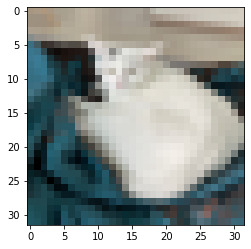

In [ ]:
## Read image from file and resize to 64 x 64
image = Image.open(os.path.join('/content/drive/My Drive',FOLDER,'아갱1.jpg')).resize((32,32))

## Convert PIL image to network input as given by
x = transform(image).unsqueeze(0)

## Check that the dimension is the same as in training
print('Size of x is',x.size())

classifier.eval()

with torch.no_grad():
  y_pred = classifier(x.cuda())
  y_prob = torch.nn.functional.softmax(y_pred,dim=1)
  label = torch.argmax(y_prob).item()

plt.imshow(image, cmap='gray')

print('Output is',classes[label],'with probability',torch.max(y_prob).item())

This image that had previously been falsely classified as a dog with 91% probability is now correctly being classified as a cat with nearly 96% probability. Great!